<center>
    <h1> Study of the Covid-19 Vaccine Acceptance</h1>
    <h4> BDA Fall 2020 - Final Project </h4>
    <hr>
    <br><br>
    <h3>Rafel Palliser & Albert Rial</h3>
    <br><br>
</center>

## 1. Problem description

The goal of this study is to analyze the acceptance of the Covid-19 Vaccine by examinating tweets referring to it. We truly think this is an important study because Covid-19 has drastically changed our lives, and its vaccine could change them again.

The followed pipeline starts by gathering the data throughout the Twitter API and storing it into a MongoDB. Once done, we perform a first data exploration to study the different fields contained in a tweet, and if there are missing values in the fields we need for our analysis. Afterwards, the data is processed and cleaned in order to be completely prepared for the study of the vaccine acceptance.

ALGO MAS?!?

Introducció:
- Storytelling
- (Done) Com fer la query? Quina? (volíem dades al llarg de molt temps, no d'un instant concret)
- (Done) covid té hashtag, vacuna no --> triar idiomes --> query #covid 24h ......

Data Exploration:
- Estudi de fields
- Quants són rt, originals, ..?
- Estudi de missing values i com estan codificats dels que ens afecten (text, geo)
- Explicar GEO!!!
- Distribució idiomes
- Llista / Mapa d'on estan els tweets
- Evolució del nb de tweets al llarg del temps (histograma..) (incloure notícies)
- Llista de top hashtags
- Llista top words (exclude stopwords,...)?

Estudi. Study on the acceptance of covid-19 vaccine:
- Mapa / Dist d'on es parla més de cada vacuna (mirar la distribució de la vacuna que es parla més segons el país)
- Evolució del sentiment al llarg del temps (relació amb notícies)
- Evolució del sentiment al llarg del temps de cada vacuna
- Sentiment segons pais. Mapa global de pro-vaccine i anti-vaccine
- Sentiment segons pais i vacuna?

Hagués estat bé tenir edat/sexe per fer estudi sociologic però no el tenim.

## 2. Data gathering and storage

Data gathering is one of the most important parts of a data project or analysis, although it may not seem so. Sometimes the researcher cannot control this part because others gathered the data, and have to face other more complicated problems to process it and extract valuable information. In this project, we have the opportunity to design the data gathering process, and that's why we have spend much time on it.

The constraints on our data gathering process come from the theme of this project, Covid-19 Vaccine Acceptance, and the source we have decided to use, Twitter. Knowing that one of the key interaction factors of this social network are the use of hashtags, we noticed the fact that the Covid-19 Vaccine has not a hashtag associated to it, or at least not a global one in a similar way that Covid-19 has #Covid, #Covid19 or #Covid-19.

Also, the word vaccine is written in different ways depending on the language, so in order to not introduce a large bias on languages due to our query, we made a preliminar study of the most used languages in tweets talking about Covid-19. Trying to be as fair as possible, we collected tweets for exactly 24h (to not discriminate any time zone) containing one of the mentioned hashtags associated with Covid-19. We are aware that countries using a non-latin alphabet may refer to the virus in a different way, but we don't aim to obtain tweets in those languages as we won't be able to process the tweet text in our analysis. Taking this into account, we obtained the following results:

In [1]:
import pymongo
from src.keys import MONGODB_KEY
from bson.son import SON

client = pymongo.MongoClient('fpsds.synology.me', 27017, username='mongoadmin', password=MONGODB_KEY)
tweets = client['tweets']['covid_hashtags_24h']

In [2]:
pipeline = [
    {'$group': {'_id': '$lang', 'count': {'$sum': 1}}},
    {"$sort": SON([("count", pymongo.DESCENDING)])},
    {'$limit': 10}
]
tot = tweets.count_documents({})
res = tweets.aggregate(pipeline)
acc = 0
langs = []
counts = []
print('Lang         %       Acc %')
for lang in res:
    langs.append(lang['_id'])
    counts.append(lang['count'])
    acc += lang['count']
    print('{:4s}    {:5.2f}%      {:5.2f}%'.format(lang['_id'], 100*lang['count']/tot, 100*acc/tot))

Lang         %       Acc %
en      61.58%      61.58%
es      17.08%      78.66%
fr       5.11%      83.77%
it       2.87%      86.63%
und      2.26%      88.90%
de       1.98%      90.88%
in       1.42%      92.30%
hi       1.22%      93.52%
ja       0.95%      94.47%
pt       0.93%      95.41%


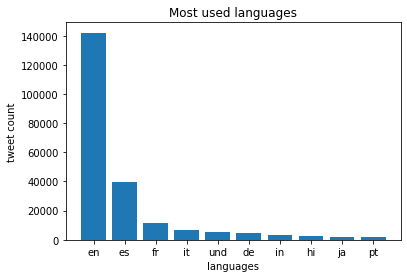

In [5]:
from src.plots import barplot
barplot(langs, counts, 'Most used languages', 'languages', 'tweet count')

Note that more than 60% of tweets are written in English, and another 17% in Spanish. The following most used language is French, which appears in 5% of the tweets, and the subsequent languages are only used in less than 3% of tweets. Looking at the histogram, it seems that the most logical choice would be to only look for tweets written in English. However, as these only cover the 60% of the gathered ones, we decided to also look after the Spanish ones, thus increasing our coverage to almost 80%.

Note that this is an approximation, assuming the tweets talking about the Covid-19 vaccine follow the same language distribution that the ones talking about Covid-19 generally.

### The actual data gathering process

The [Twitter API](https://developer.twitter.com/en) provides two main ways of gathering tweets. On one side we have the streaming option, which gets the tweets matching a certain query in real time. On the other, we have the option of dowloading indexed tweets from their database, from which one can download data from the 7-10 prior days with a free developer account.

After testing both options, we decided to go for the second one, as we could make queries every 7 days and obtain the tweets for the whole period without having to leave a computer running a script 24/7, much more time. Also, we predicted (now confirmed) that during December the vaccine topic would become more and more trendy, so we wanted to download tweets for a long period of time.

[src/collect_tweets.py](src/collect_tweets.py) is the script we have been using to download tweets and insert them in a database. We decided to not include the code in this notebook but leave it in a separate file because we run it asynchronously. In the file, one can see we have used [Tweepy](https://www.tweepy.org/) (a python library wrapping the Twitter API) and the actual parameters we have used to gather tweets. Apart from 'since', and 'until', which serve to control the period of time from we desire to download tweets, the most important one is the query itself: **'#covid OR #covid19 vaccine OR vacuna'**.

In the [documentation](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/guides/standard-operators) it can be easily seen that the 'OR' operator works as a logical OR betweet the two contiguous terms, and a simple whitespace works as an AND. Therefore, we are looking for tweets that contain (#covid or #covid19) and (vaccine or vacuna). The first part is to ensure the resulting tweets refer to the Covid-19 vaccine (note that #covid also matches #covid-19, so we are covering all the three most-used global hashtags for Covid-19). The second part is to ensure that the tweets specifically refer to the vaccine, and we include the word in English and Spanish as we decided in the previous language study because there is not a unified term to refer to the vaccine globaly. Note that we search for the word and not the hashtag, because although local hashtags #vaccine or #vacuna exists, few people use them. Also note that the way the Twitter search work, our query 'vaccine' also matches a possible hashtag '#vaccine', so we are not losing these results.

We have been running this script from November, 29 to XXXX and collected a total amount of XXXX tweets, which have been stored into a MongoDB database.

### Storage

Relational databases are a efficient solution for storage, but require strictly structured data, which does not directly match with tweets, which come in a json format and with several different fields depending on the type of tweet. For this reason, we have decided to use a NoSQL database. Specificaly we have chosen [MongoDB](https://www.mongodb.com/es), which is document oriented and matches the data type perfectly (json-like objects). The fact that we already know its language and it has a Python library ([PyMongo](https://pypi.org/project/pymongo/)) ready to use also played a role in our decision.

For this project, we set up a MongoDB server using [Docker](https://www.docker.com/), and left it running in a machine which is visible in the public network, so we are able to work from home with an online, up-to-date and synchronized database, which is always available.

## 3. Data description

**Connection with the DB**

In [1]:
import json
import pymongo
from keys import MONGODB_KEY
from pymongo import MongoClient

client = pymongo.MongoClient('fpsds.synology.me', 27017, username='mongoadmin', password=MONGODB_KEY)

# let's get the list of DBs already defined
print(client.list_database_names())

# Get the DB we want to use
tweets = client['tweets']['#covid_vaccine']

['admin', 'config', 'geo', 'local', 'tweets']


In [8]:
from bson.son import SON

Show an example of data sample

In [27]:
tweets.find_one({})

{'_id': 1334789658442665985,
 'created_at': 'Fri Dec 04 09:20:28 +0000 2020',
 'full_text': 'RT @21WIRE: UPDATE: Despite concerns about safety &amp; trial design, countries are already spending billions of dollars in taxpayer funds to p…',
 'display_text_range': [0, 144],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': '21WIRE',
    'name': 'Patrick Henningsen',
    'id': 16936686,
    'id_str': '16936686',
    'indices': [3, 10]}],
  'urls': []},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'geo': None,
 'coordinates': None,
 'place': None,
 'retweet_count': 25,
 'favorite_count': 0}

**Count the total number of tweets on the database and the number of tweets with geolocation**

In [16]:
print("Total number of tweets:", tweets.count_documents({}))

Total number of tweets: 68822


In [26]:
count_with_geo = tweets.count_documents({'$or': [
                                                {'geo': {'$ne': None}}, 
                                                {'coordinates': {'$ne': None}},
                                                {'place': {'$ne': None}}
                                        ]},{})
print("Number of tweets with geolocation:", count_with_geo)

Number of tweets with geolocation: 931


**Top 25 vaccine related hashtags**

In [37]:
from bson.son import SON

pipeline = [
        {'$unwind': "$entities.hashtags" },
        {'$group': {'_id': '$entities.hashtags.text', 'count': {'$sum': 1}}},
        {"$sort": SON([("count", pymongo.DESCENDING)])},
        {'$limit': 25}
    ]

res = tweets.aggregate(pipeline)
for sample in res:
    print(sample)

{'_id': 'vaccine', 'count': 42747}
{'_id': 'COVID19', 'count': 15302}
{'_id': 'Vaccine', 'count': 9458}
{'_id': 'coronavirus', 'count': 3461}
{'_id': 'COVID', 'count': 3160}
{'_id': 'Covid', 'count': 3068}
{'_id': 'Pfizer', 'count': 2682}
{'_id': 'Covid19', 'count': 2489}
{'_id': 'CovidVaccine', 'count': 2459}
{'_id': 'patents', 'count': 1854}
{'_id': 'COVIDー19', 'count': 1818}
{'_id': 'covid19', 'count': 1412}
{'_id': 'AstraZeneca', 'count': 1315}
{'_id': 'vaccination', 'count': 1207}
{'_id': 'covid', 'count': 1167}
{'_id': 'UK', 'count': 1123}
{'_id': 'BillGates', 'count': 962}
{'_id': 'pandemic', 'count': 794}
{'_id': 'Vaccination', 'count': 789}
{'_id': 'cdc', 'count': 783}
{'_id': 'Moderna', 'count': 777}
{'_id': 'vaccines', 'count': 766}
{'_id': 'GatesFoundation', 'count': 736}
{'_id': 'UN', 'count': 721}
{'_id': 'GAVI', 'count': 718}


In [2]:
r = tweets.count_documents({})
print(r)

721077


In [4]:
have_place = tweets.count_documents({'place': {'$ne': None}})
have_geo = tweets.count_documents({'geo': {'$ne': None}})
have_coordinates = tweets.count_documents({'coordinates': {'$ne': None}})
print(have_place, 100*have_place/r)
print(have_geo, 100*have_geo/r)
print(have_coordinates, 100*have_coordinates/r)

4980 0.6906335939157676
108 0.014977596012631106
108 0.014977596012631106


In [5]:
have_user_loc = tweets.count_documents({'user.location': {'$ne': ''}})
print(have_user_loc, 100*have_user_loc/r)

504936 70.02525389105463


In [6]:
have_my_geo = tweets.count_documents({'my_geo': {'$ne': None}})
print(have_my_geo, 100*have_my_geo/r)

353979 49.0903190643995


In [13]:
pip = [
    {'$group': {'_id': '$lang', 'count': {'$sum': 1}}},
    {'$sort': SON([('count', pymongo.DESCENDING)])},
    {'$limit': 10}
]
languages = tweets.aggregate(pip)
for lang in languages:
    print(lang)

{'_id': 'en', 'count': 531462}
{'_id': 'es', 'count': 106193}
{'_id': 'fr', 'count': 57837}
{'_id': 'und', 'count': 7199}
{'_id': 'hi', 'count': 3637}
{'_id': 'nl', 'count': 2285}
{'_id': 'ca', 'count': 1801}
{'_id': 'in', 'count': 1378}
{'_id': 'tl', 'count': 1190}
{'_id': 'pt', 'count': 963}


In [14]:
pip = [
    {'$match': {'my_geo': {'$ne': None}}},
    {'$group': {'_id': '$my_geo.country', 'count': {'$sum': 1}}},
    {'$sort': SON([('count', pymongo.DESCENDING)])},
    {'$limit': 10}
]
countries = tweets.aggregate(pip)
for country in countries:
    print(country)

{'_id': 'United States', 'count': 177805}
{'_id': 'United Kingdom', 'count': 32726}
{'_id': 'Canada', 'count': 24412}
{'_id': 'India', 'count': 17992}
{'_id': 'France', 'count': 16476}
{'_id': 'Mexico', 'count': 8866}
{'_id': 'Spain', 'count': 7249}
{'_id': 'Ecuador', 'count': 5053}
{'_id': 'Australia', 'count': 3793}
{'_id': 'Germany', 'count': 3237}
